In [23]:
import numpy as np
from tqdm import tqdm
import random
import gymnasium as gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import deque

In [24]:
#Setting up the environment
env = gym.make('Taxi-v3', render_mode='ansi')
state, _ = env.reset()

# The state of the environment
print(state)

print("decoded state")
print(list(env.decode(state)))


#The number of states in the environment
print(env.observation_space.n)

#The number of actions in the environment
print(env.action_space.n)

#Take a step in the environment
next_state, reward, done, _, _ = env.step(1)
print("decoded state")
print(list(env.decode(next_state)))

#Render the environment
env.render()

54
decoded state
[0, 2, 3, 2]
500
6
decoded state
[0, 2, 3, 2]


c:\Users\maste\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


'+---------+\n|R: |\x1b \x1b: :G|\n| : | : : |\n| : : : : |\n| | : | : |\n|\x1bY\x1b| : |\x1bB\x1b: |\n+---------+\n  (North)\n'

In [25]:
total_options = 10
# actions:  ['up', 'right', 'down', 'left', 'pickup', 'dropoff']
actions = [0, 1, 2, 3, 4, 5]
# options: ['toR', 'toG', 'toY', 'toB']
options = [6, 7, 8, 9]
goal_states = [[0, 0], [0, 4], [4, 0], [4, 3]]
Q_values = np.zeros((env.observation_space.n, total_options))
Q_options = np.zeros((len(options), 25, 4))
print(Q_values.T[:6].T.shape)

# Softmax function
def softmax(Q_values, state, tau):
    q_values = Q_values[state]
    q_values = q_values / tau
    max_q = np.max(q_values)
    e = np.exp(q_values - max_q)
    dist = e / np.sum(e)
    action = np.random.choice(len(dist), p=dist)
    return action

(500, 6)


In [26]:
def execute_option(Q_values, option, state):
    optdone = False
    optact = 0

    decoded_state = list(env.decode(state))
    if decoded_state[0:2] == goal_states[option - 6]:
        optdone = True
    optact = softmax(Q_values=Q_options[option - 6], state=5*decoded_state[0] + decoded_state[1], tau=0.1)

    return optact, optdone

In [27]:
#### SMDP Q-Learning
action_visits = np.zeros((total_options))
episodes = 5000
total_rewards = np.zeros((episodes))
# Add parameters you might need here
gamma = 0.99
alpha = 0.1
# Iterate over 1000 episodes
for i in tqdm(range(episodes)):
    state, _ = env.reset()    
    done = False
    # While episode is not over
    while not done:
        
        # Choose action        
        action = softmax(Q_values, state, tau=1)
        action_visits[action] += 1

        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done, _, _ = env.step(action)
            Q_values[state, action] += alpha * (reward + gamma * np.max(Q_values[next_state]) - Q_values[state, action])
            state = next_state
            total_rewards[i] += reward
            
            
        # Checking if action chosen is an option
        reward_bar = 0
        if action >= 6: # action => Away option
            count = 0
            optdone = False
            current_state = state
            while (optdone == False):
                optact,optdone = execute_option(Q_options, action, state)
                next_state, reward, done, _, _ = env.step(optact)

                decoded_state = list(env.decode(state)) 
                decoded_next_state = list(env.decode(next_state))

                decoded_state_grid_pos = 5*decoded_state[0] + decoded_state[1]
                decoded_next_state_grid_pos = 5*decoded_next_state[0] + decoded_next_state[1]

                goal = goal_states[action - 6]
                
                pseudo_reward = 30 if decoded_next_state[0:2] == goal else 0

                Q_options[action - 6, decoded_state_grid_pos, optact] += alpha * (reward + pseudo_reward + gamma * np.max(Q_options[action - 6, decoded_next_state_grid_pos]) - Q_options[action - 6, decoded_state_grid_pos, optact ])

                reward_bar = reward_bar + gamma**count*reward
                count += 1
                if optdone == True:
                    total_rewards[i] += reward_bar
                    Q_values[current_state, action] += alpha * (reward_bar - Q_values[current_state, action] + gamma**count * np.max(Q_values[next_state]))
                state = next_state


100%|██████████| 5000/5000 [00:14<00:00, 336.57it/s]


In [28]:
def plot_rewards(rewards):
    avg_rew = []
    plt.figure("Reward Plot")
    scores_window = deque(maxlen=300)
    for reward in rewards:
        scores_window.append(reward)
        avg_rew.append(np.mean(scores_window))
    plt.plot(avg_rew)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.ylim(-200, 200)  # Set the Y-axis range


3.8767031578990445


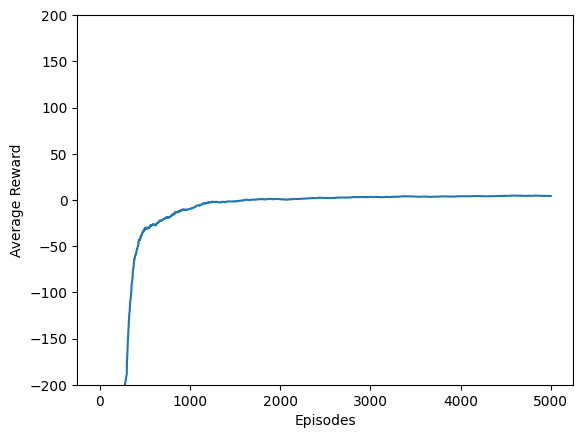

In [29]:
plot_rewards(total_rewards)
print(np.mean(total_rewards[-100:]))

In [30]:
def options_plot(Q_options):
    GOAL_STATES = [[0, 0], [0, 4], [4, 0], [4, 3]]
    actions = ['up', 'right', 'down', 'left']
    integer = 0
    for i in Q_options:
        Q_map = np.zeros((5,5))
        for j in range(25):
            Q_map[j//5, j%5] = np.argmax(i[j])

        fig, ax = plt.subplots()
        ax.imshow(Q_map, cmap='hot')

        # Plot goal states in green
        ax.add_patch(plt.Rectangle((GOAL_STATES[integer][1]-0.5, GOAL_STATES[integer][0]-0.5), 1, 1, color='green'))
        # for j in range(25):
        #     ax.text(j%5, j//5, actions[int(Q_map[j//5, j%5])], color='white', fontsize=12, ha='center', va='center')
        integer += 1
        for x in range(5):
            for y in range(5):
                action = Q_map[x, y]
                dx = 0
                dy = 0
                if action == 0:  # up
                    dy = -0.4
                elif action == 1:  # right
                    dx = 0.4
                elif action == 2:  # down
                    dy = 0.4
                elif action == 3:  # left
                    dx = -0.4

                ax.annotate("", xy=(y+dx, x+dy), xytext=(y, x),
                            arrowprops=dict(arrowstyle="->", color='blue'))

[-4.73107826e-01  1.26913844e+03 -5.70873183e-01 -5.10899143e-01]


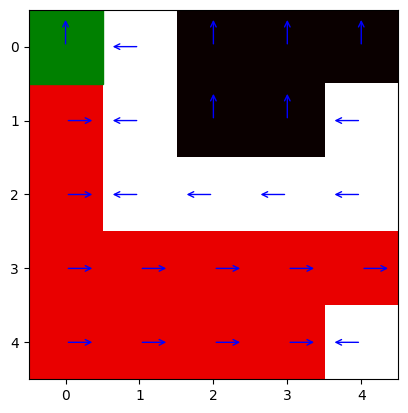

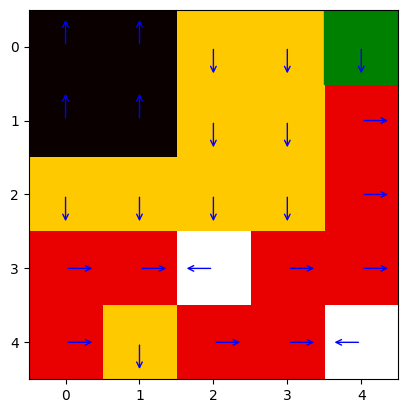

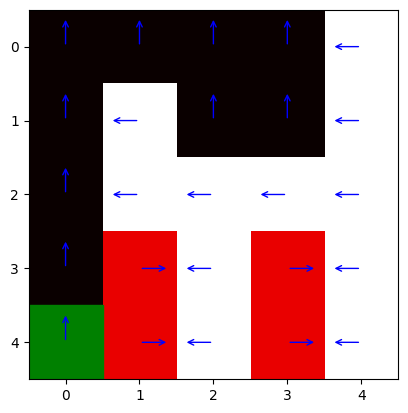

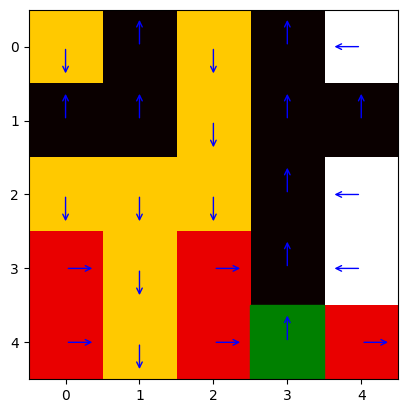

In [39]:
options_plot(Q_options)
print(np.argmax(Q_options[0][3]))

In [32]:
action_visits

array([7087., 9823., 7042., 6803., 6335., 6357., 4152., 4365., 4567.,
       4558.])

In [33]:
# # env = gym.make('Taxi-v3', render_mode='human')
# state, _ = env.reset()    
# done = False
# rewards.append(0)
# env.render()
# while not done:
        
#         # Choose action        
#         action = softmax(Q_values, state, tau=1)
#         action_visits[action] += 1
#         # Checking if primitive action
#         if action < 6:
#             # Perform regular Q-Learning update for state-action pair
#             next_state, reward, done, _, _ = env.step(action)
#             Q_values[state, action] += alpha * (reward + gamma * np.max(Q_values[next_state]) - Q_values[state, action])
#             state = next_state
#             rewards[i] += reward
            
            
#         # Checking if action chosen is an option
#         reward_bar = 0
#         if action >= 6: # action => Away option
#             count = 0
#             optdone = False
#             optact = 11
#             current_state = state
#             while (optdone == False):
#                 optact,optdone = execute_option(Q_options , action, state)
#                 next_state, reward, done, _, _ = env.step(optact)

#                 decoded_state = list(env.decode(state))
#                 decoded_next_state = list(env.decode(next_state))

#                 decoded_state_state = 5*decoded_state[0] + decoded_state[1]
#                 decoded_next_state_state = 5*decoded_next_state[0] + decoded_next_state[1]

#                 Q_options[ action - 6, decoded_state_state, optact] += alpha * (reward + gamma * np.max(Q_options[action - 6, decoded_next_state_state]) - Q_options[action - 6, decoded_state_state, optact ])

#                 reward_bar = reward_bar + gamma**count*reward
#                 count += 1
#                 rewards[i] += reward_bar
#                 if optdone == True:
#                     Q_values[current_state, action] += alpha * (reward_bar - Q_values[current_state, action] + gamma**count * np.max(Q_values[next_state]))
#                 state = next_state